# Training a neural network with McSnow autoconversion output

This script applies a DNN to the regression problem for warm-rain parameterization

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [2]:
tf.random.set_seed(1234)

### Load data from netcdf

In [3]:
import numpy as np
import xarray as xr

In [4]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="big_n5"

fname1=mdir+edir+'autocon_train_'+data+'.nc'
fname2=mdir+edir+'autocon_test_'+data+'.nc'
fname3=mdir+edir+'autocon_val_big_n2.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
ds2 = xr.open_dataset(fname3)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 6, ii: 6, j: 7, jj: 7, k: 5, kk: 5, n: 5, nn: 5, nt: 4000)
Coordinates:
  * n           (n) int32 0 1 2 3 4
  * i           (i) int32 200 400 600 800 1000 2000
  * j           (j) int32 9 10 11 12 13 14 15
  * k           (k) int32 0 1 2 3 4
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n

# Prepare data for training

In [5]:
def read_and_prepare_data(fname,ZERO):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    auto = xr.open_dataset(fname).auto_mass.values
    autoN = xr.open_dataset(fname).auto_num.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    nu   = xr.open_dataset(fname).nu.values
    # lower bound based on input
    auto = np.where(auto>ZERO, auto, np.nan*auto)
    # numerical lower bounds
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    auto_min = 1e-15
    # transform everything except nu in log space
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    auto  = np.log(auto,  where=auto>auto_min,  out=np.nan*auto)
    autoN = np.log(autoN, where=autoN>auto_min, out=np.nan*autoN)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ auto.ravel(), autoN.ravel(), Lc.ravel(), Xc.ravel(), Lr.ravel(), tau.ravel(), nu.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['auto','autoN','Lc','Xc','Lr','tau','nu'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [6]:

ZERO=1e-12
Zstring=-np.log10(ZERO)

data=data+'_z%d'%Zstring    

dataset_train = read_and_prepare_data(fname1,ZERO)
dataset_test = read_and_prepare_data(fname2,ZERO)
dataset_val = read_and_prepare_data(fname3,ZERO)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encoun

### Inspect the data

In [7]:
dataset_train.head()

auto     autoN        Lc         Xc         Lr        tau   nu
172 -25.749601 -3.753952 -8.522170 -26.486105 -22.683212 -14.161042  0.0
190 -24.644072 -2.579818 -8.522176 -26.484543 -21.242086 -12.719914  0.0
225 -27.129719 -5.077285 -8.522176 -26.479517 -20.714743 -12.192572  0.0
238 -27.064310 -5.003683 -8.522181 -26.477623 -20.440714 -11.918540  0.0
241 -26.347454 -4.291258 -8.522181 -26.477005 -20.363628 -11.841455  0.0

In [8]:
dataset_test.head()

auto     autoN        Lc         Xc         Lr        tau   nu
209 -26.220205 -4.159856 -8.113740 -26.474306 -22.481749 -14.368010  0.5
233 -25.556261 -3.502297 -8.113744 -26.468613 -21.432177 -13.318435  0.5
249 -26.613731 -4.549329 -8.113744 -26.464346 -20.937717 -12.823977  0.5
252 -22.757528 -0.702263 -8.113753 -26.463634 -19.478518 -11.364776  0.5
259 -26.145216 -4.081081 -8.113753 -26.461935 -19.382215 -11.268474  0.5

In [9]:
dataset_train.describe()

auto          autoN             Lc             Xc  \
count  197801.000000  197801.000000  197801.000000  197801.000000   
mean      -22.026894       0.023608      -8.198066     -25.731426   
std         2.920385       2.917543       1.049897       0.506355   
min       -27.630911      -5.820764     -14.715891     -28.226362   
25%       -24.325216      -2.272677      -8.611493     -26.127008   
50%       -21.943462       0.105629      -8.083423     -25.788382   
75%       -19.762575       2.283464      -7.424066     -25.340471   
max       -13.795737       8.222481      -6.215683     -24.881920   

                  Lr            tau             nu  
count  197801.000000  197801.000000  197801.000000  
mean      -11.760656      -4.070483       1.941133  
std         3.735635       3.678111       1.393658  
min       -24.611513     -18.395769       0.000000  
25%       -14.191019      -6.386972       1.000000  
50%       -10.990004      -3.159184       2.000000  
75%        -8.714407      -0.857866       3.000000  
max        -6.217121      -0.001029       4.000000

In [10]:
dataset_test.describe()

auto          autoN             Lc             Xc  \
count  127532.000000  127532.000000  127532.000000  127532.000000   
mean      -21.860394       0.189108      -8.054729     -25.728098   
std         2.876611       2.871681       1.028031       0.494627   
min       -27.630722      -5.982418     -14.928525     -27.567888   
25%       -24.100558      -2.046173      -8.327821     -26.125248   
50%       -21.691131       0.361147      -8.063953     -25.811378   
75%       -19.590716       2.455126      -7.298653     -25.339934   
max       -14.564456       7.457858      -6.503471     -24.882586   

                  Lr            tau             nu  
count  127532.000000  127532.000000  127532.000000  
mean      -11.641980      -4.129126       1.976704  
std         3.828627       3.797787       1.109289  
min       -24.583874     -18.069786       0.500000  
25%       -14.168396      -6.588104       0.500000  
50%       -10.744680      -3.154546       1.500000  
75%        -8.410520      -0.758932       2.500000  
max        -6.505355      -0.001018       3.500000

### Further reduce data to relevant parameter range for autoconversion

In [11]:
def reduce_data(dataset):
    idx = dataset[ dataset['tau'] > np.log(0.85) ].index
    dataset.drop(idx,inplace=True)
    return dataset

In [12]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)


In [13]:
dataset_train.describe()

auto          autoN             Lc             Xc  \
count  179133.000000  179133.000000  179133.000000  179133.000000   
mean      -21.826139       0.225292      -7.979896     -25.714218   
std         2.919363       2.916017       0.784253       0.493727   
min       -27.630911      -5.820764     -10.417499     -26.839777   
25%       -24.084719      -2.031040      -8.534441     -26.122381   
50%       -21.662224       0.388861      -7.879561     -25.689709   
75%       -19.567558       2.479618      -7.420526     -25.338396   
max       -13.795737       8.222481      -6.215683     -24.881920   

                  Lr            tau             nu  
count  179133.000000  179133.000000  179133.000000  
mean      -12.216734      -4.487272       1.972903  
std         3.627569       3.619168       1.389938  
min       -24.611513     -18.395769       0.000000  
25%       -14.571661      -6.776233       1.000000  
50%       -11.522158      -3.695059       2.000000  
75%        -9.241595      -1.387762       3.000000  
max        -6.378722      -0.162541       4.000000

In [14]:
dataset_test.describe()

auto          autoN             Lc             Xc  \
count  114312.000000  114312.000000  114312.000000  114312.000000   
mean      -21.607359       0.442984      -7.800608     -25.721569   
std         2.849338       2.843499       0.671941       0.491117   
min       -27.630722      -5.745473     -10.008868     -26.690422   
25%       -23.751327      -1.697102      -8.147650     -26.123439   
50%       -21.346679       0.705893      -7.723305     -25.815642   
75%       -19.378059       2.668540      -7.270895     -25.339330   
max       -14.564456       7.457858      -6.503471     -24.882586   

                  Lr            tau             nu  
count  114312.000000  114312.000000  114312.000000  
mean      -12.137192      -4.598324       1.998040  
std         3.736264       3.737306       1.107676  
min       -24.583874     -18.069786       0.500000  
25%       -14.604690      -7.034030       1.500000  
50%       -11.372342      -3.786315       1.500000  
75%        -8.962379      -1.344769       2.500000  
max        -6.666332      -0.162521       3.500000

In [15]:
dataset_val.describe()

auto         autoN            Lc            Xc            Lr  \
count  71375.000000  71375.000000  71375.000000  71375.000000  71375.000000   
mean     -21.827398      0.224636     -7.982384    -25.711500    -12.219398   
std        2.917896      2.914958      0.785831      0.491084      3.627964   
min      -27.630791     -5.742925    -10.416255    -26.837416    -24.556349   
25%      -24.098772     -2.044851     -8.533689    -26.120022    -14.585513   
50%      -21.652399      0.398091     -7.880838    -25.651936    -11.525882   
75%      -19.571098      2.475958     -7.420605    -25.339108     -9.240797   
max      -13.839059      8.176001     -6.215693    -24.883766     -6.378899   

                tau            nu  
count  71375.000000  71375.000000  
mean      -4.489914      1.978942  
std        3.613399      1.393436  
min      -18.136951      0.000000  
25%       -6.789004      1.000000  
50%       -3.703246      2.000000  
75%       -1.393475      3.000000  
max       -0.162536      4.000000

### Pairplot

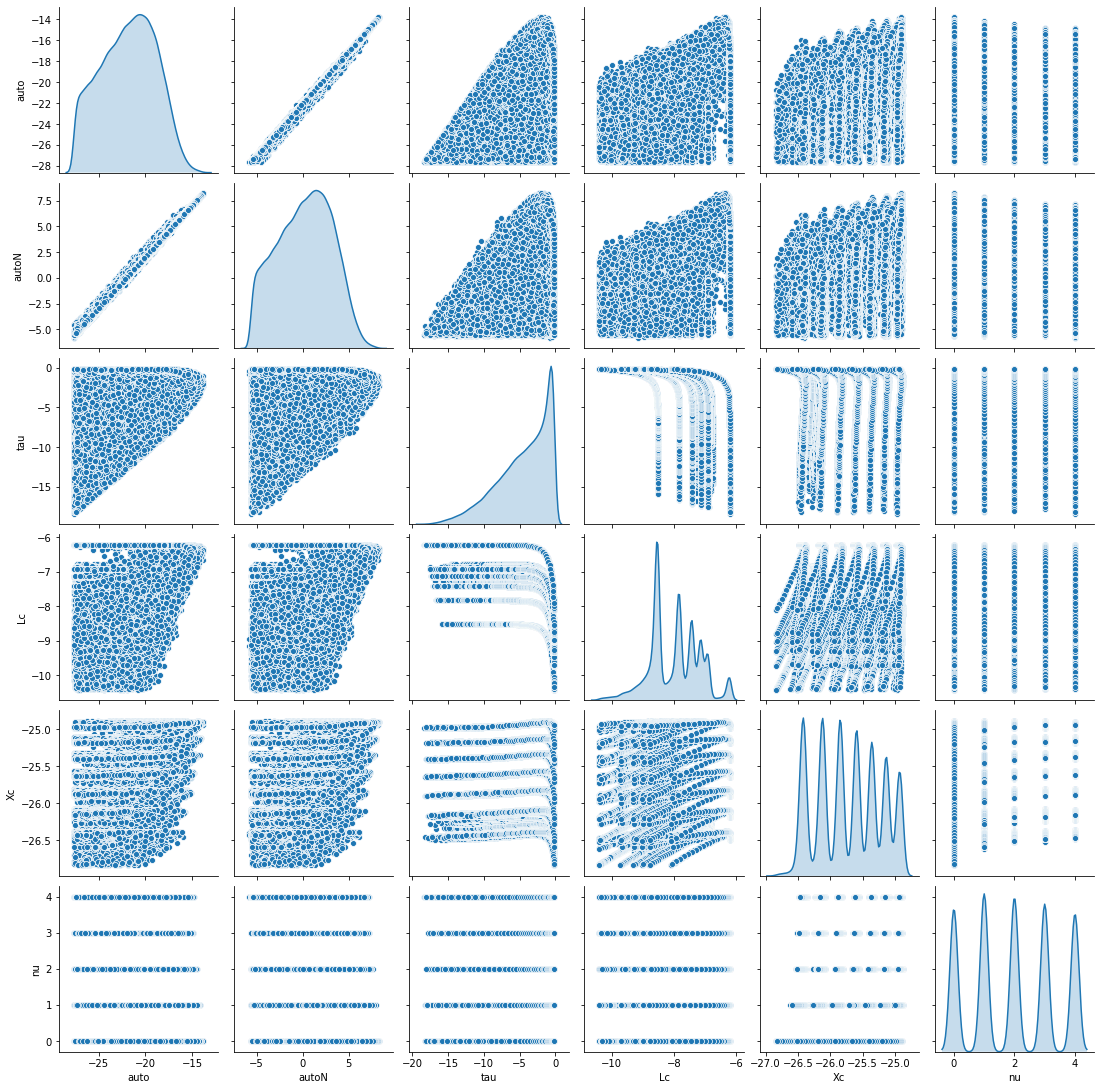

In [16]:
sns.pairplot(dataset_train[["auto","autoN","tau","Lc","Xc",'nu']], diag_kind="kde")

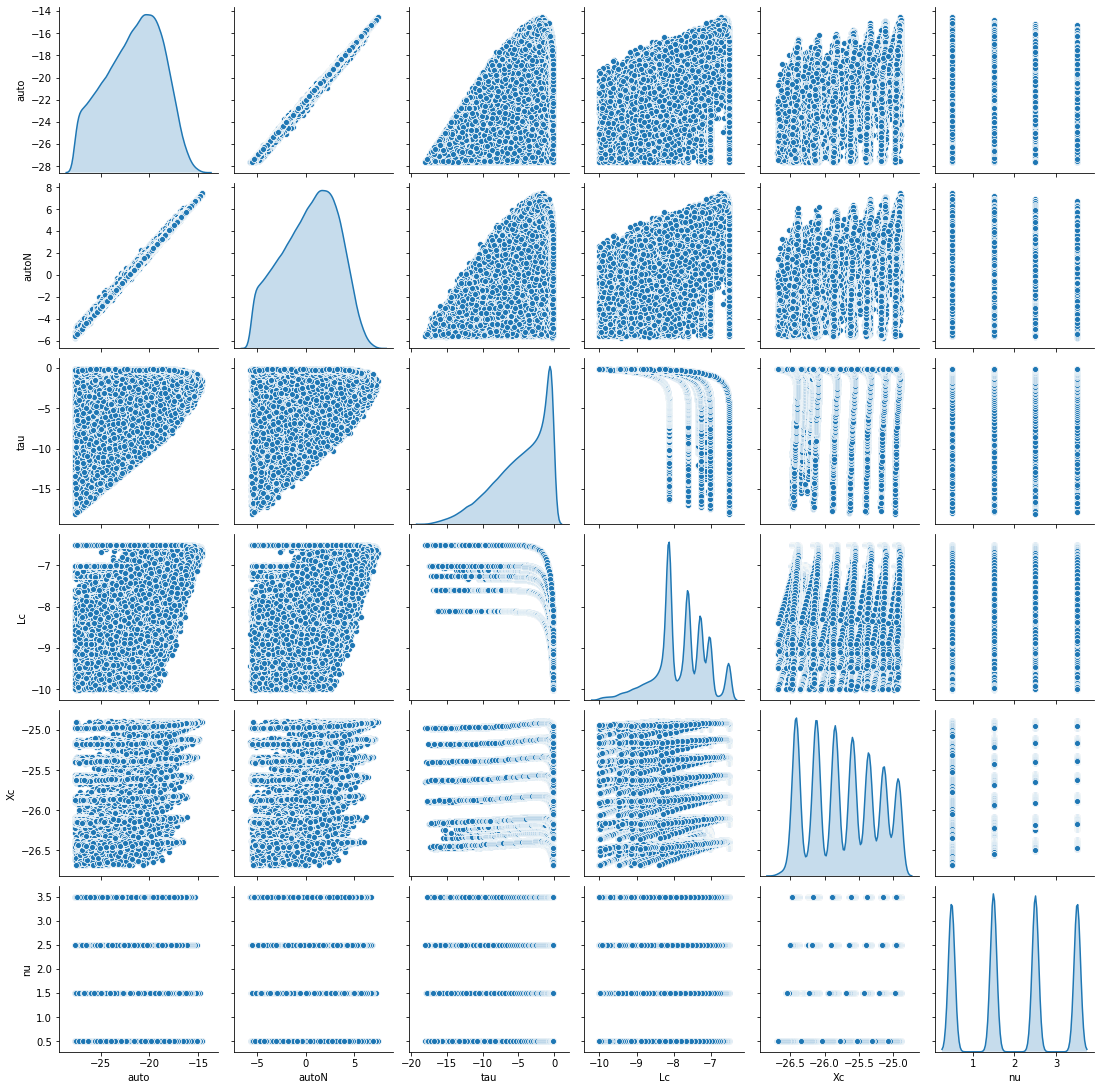

In [17]:
sns.pairplot(dataset_test[["auto","autoN","tau","Lc","Xc",'nu']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [18]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [19]:
test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [20]:
val_dataset0 = dataset_val.copy()
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()

In [21]:
train_dataset2 = train_dataset2.drop(['tau'], axis=1)
train_dataset3 = train_dataset3.drop(['Lr'], axis=1)

In [22]:
test_dataset2 = test_dataset2.drop(['tau'], axis=1)
test_dataset3 = test_dataset3.drop(['Lr'], axis=1)

In [23]:
val_dataset2 = val_dataset2.drop(['tau'], axis=1)
val_dataset3 = val_dataset3.drop(['Lr'], axis=1)

In [24]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("auto")
train_stats2.pop("autoN")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  179133.0  -7.979896  0.784253 -10.417499  -8.534441  -7.879561  -7.420526   
Xc  179133.0 -25.714218  0.493727 -26.839777 -26.122381 -25.689709 -25.338396   
Lr  179133.0 -12.216734  3.627569 -24.611513 -14.571661 -11.522158  -9.241595   
nu  179133.0   1.972903  1.389938   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215683  
Xc -24.881920  
Lr  -6.378722  
nu   4.000000

In [25]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("auto")
train_stats3.pop("autoN")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%  \
Lc   179133.0  -7.979896  0.784253 -10.417499  -8.534441  -7.879561   
Xc   179133.0 -25.714218  0.493727 -26.839777 -26.122381 -25.689709   
tau  179133.0  -4.487272  3.619168 -18.395769  -6.776233  -3.695059   
nu   179133.0   1.972903  1.389938   0.000000   1.000000   2.000000   

           75%        max  
Lc   -7.420526  -6.215683  
Xc  -25.338396 -24.881920  
tau  -1.387762  -0.162541  
nu    3.000000   4.000000

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [26]:
train_labels2 = train_dataset2[['auto','autoN']].copy()
train_dataset2.drop(['auto','autoN'], axis=1, inplace=True)

test_labels2 = test_dataset2[['auto','autoN']].copy()
test_dataset2.drop(['auto','autoN'], axis=1, inplace=True)

val_labels2 = val_dataset2[['auto','autoN']].copy()
val_dataset2.drop(['auto','autoN'], axis=1, inplace=True)

In [27]:
train_labels3 = train_dataset3[['auto','autoN']].copy()
train_dataset3.drop(['auto','autoN'], axis=1, inplace=True)

test_labels3 = test_dataset3[['auto','autoN']].copy()
test_dataset3.drop(['auto','autoN'], axis=1, inplace=True)

val_labels3 = val_dataset3[['auto','autoN']].copy()
val_dataset3.drop(['auto','autoN'], axis=1, inplace=True)


In [28]:
train_labels2.describe()

auto          autoN
count  179133.000000  179133.000000
mean      -21.826139       0.225292
std         2.919363       2.916017
min       -27.630911      -5.820764
25%       -24.084719      -2.031040
50%       -21.662224       0.388861
75%       -19.567558       2.479618
max       -13.795737       8.222481

### Normalize the data

In [29]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [30]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean       std       min       25%       50%       75%  \
Lc  179133.0 -3.023821e-03  1.000004 -3.108185 -0.707100  0.127937  0.713252   
Xc  179133.0  4.627336e-04  1.000004 -2.279720 -0.826698  0.049642  0.761194   
Lr  179133.0 -1.892002e-05  1.000019 -3.416828 -0.649175  0.191472  0.820147   
nu  179133.0  2.907745e-08  0.999867 -1.419418 -0.699961  0.019495  0.738952   

         max  
Lc  2.249546  
Xc  1.685747  
Lr  1.609346  
nu  1.458408

In [31]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Lc   179133.0 -3.023821e-03  1.000004 -3.108185 -0.707100  0.127937  0.713252   
Xc   179133.0  4.627336e-04  1.000004 -2.279720 -0.826698  0.049642  0.761194   
tau  179133.0  1.412304e-06  1.000013 -3.843010 -0.632455  0.218894  0.856415   
nu   179133.0  2.907745e-08  0.999867 -1.419418 -0.699961  0.019495  0.738952   

          max  
Lc   2.249546  
Xc   1.685747  
tau  1.194952  
nu   1.458408

# The model

## Build the model

In [32]:
def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_tanh_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Deeper ReLU network
def build_model_relu_deep(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "tanh_SGD":
        model = build_model_tanh_SGD(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_deep":
        model = build_model_relu_deep(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    elif activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [33]:

#DNNstring='16x16x16'
DNNstring='16xx10'

activ = "ReLU_deep"

#activ = "sigm"
#activ = "tanh"
#activ = "SELU"
#activ = "PReLU"
#activ = "LReLU"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"
#activ = "tanh"
#activ = "tanh_SGD"

model = build_model(4,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2

Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [35]:
example_batch  = normed_train_data2[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.02619975, -0.10151567],
       [ 0.01451299, -0.08841837],
       [ 0.01049554, -0.08443138],
       [ 0.00915619, -0.08288378],
       [ 0.00877596, -0.08244412],
       [-0.00750889, -0.07138665],
       [-0.00903593, -0.07084215],
       [-0.01161753, -0.06991984],
       [-0.01187101, -0.06984085],
       [-0.01258785, -0.06957522]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [36]:
# maximum number, but we use early stopping
EPOCHS = 200

# learning rate
learn = 1e-4        # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# for collecting the histories
histories = {}

In [37]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,val_labels2], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:24.0555,  mae:2.6164,  mse:24.0556,  val_loss:2.2095,  val_mae:1.1265,  val_mse:2.2095,  
....................................................................................................
Epoch: 100, loss:1.9721,  mae:1.0381,  mse:1.9721,  val_loss:2.0034,  val_mae:1.0474,  val_mse:2.0034,  
..................................

Text(0, 0.5, 'MAE')

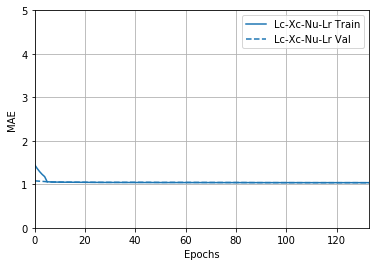

In [38]:
histories['Lc-xc-nu-Lr'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [39]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,val_labels3], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:31.7800,  mae:3.2169,  mse:31.7800,  val_loss:2.3855,  val_mae:1.1825,  val_mse:2.3855,  
..........................................................................................

Text(0, 0.5, 'MAE')

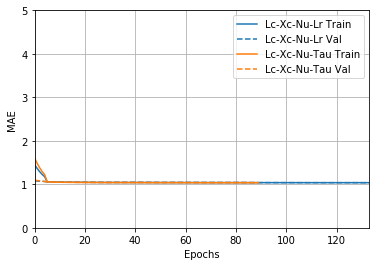

In [40]:
histories['Lc-xc-nu-tau'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [41]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

Text(0, 0.5, 'MAE')

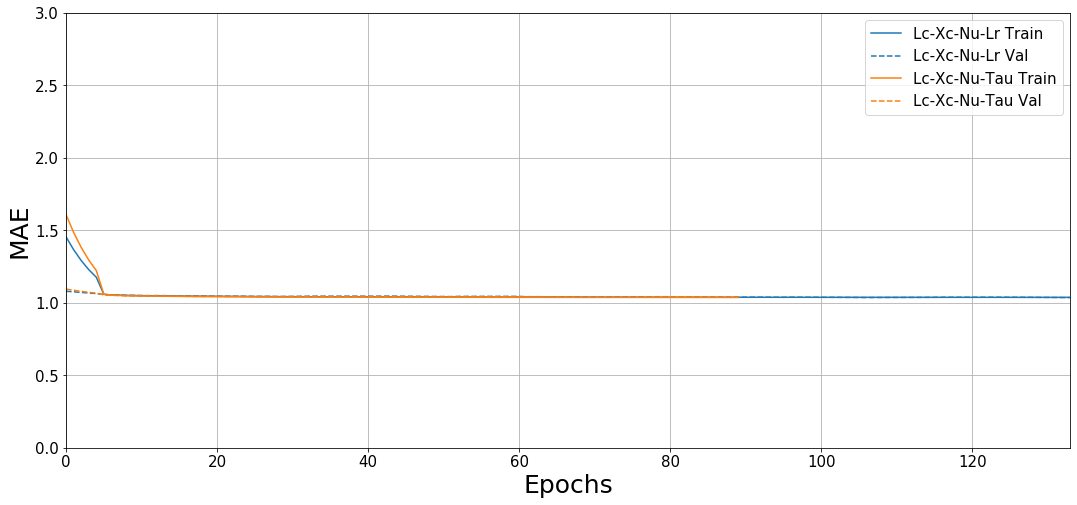

In [42]:
plotter.plot(histories, metric = "mae")
plt.ylim([0, 3])
plt.ylabel('MAE')

In [43]:
#plt.savefig("histories_MAE.png", bbox_inches='tight', dpi=600)

In [44]:
#plt.savefig("histories_MAE.pdf", bbox_inches='tight')

Text(0, 0.5, 'MSE of AU')

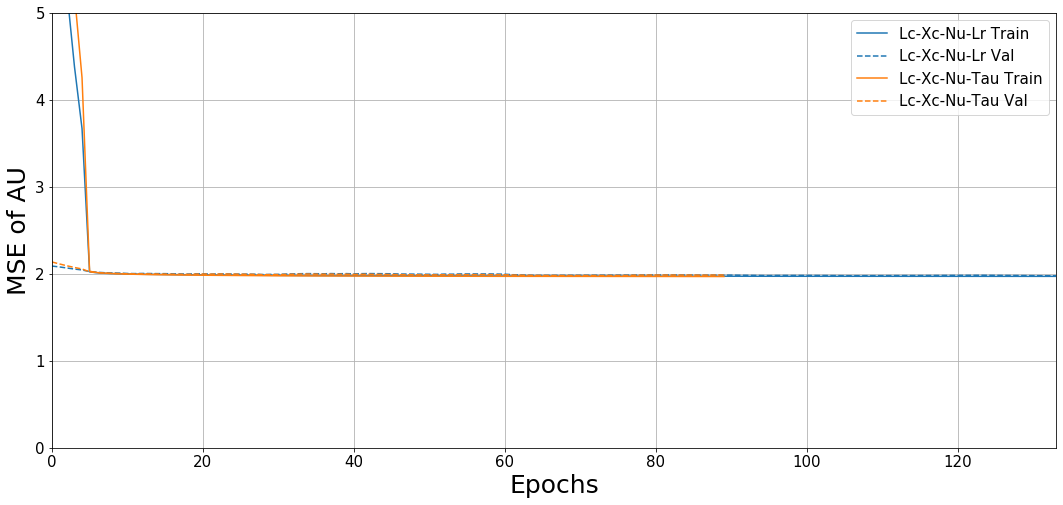

In [45]:
plotter.plot(histories, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('MSE of AU')

In [46]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

114312/114312 - 3s - loss: 1.7761 - mae: 0.9870 - mse: 1.7761
Testing set for model 2, Mean Abs Error:    0.98697


In [47]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

114312/114312 - 3s - loss: 1.7887 - mae: 0.9943 - mse: 1.7887
Testing set for model 3, Mean Abs Error:    0.99435


# Save models to file

In [48]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v9
    
model2.save('saved_model_v9/autocon_withN_LcXcNuLr_01_'+activ+'_'+DNNstring+'_'+data) 
model3.save('saved_model_v9/autocon_withN_LcXcNuTau_01_'+activ+'_'+DNNstring+'_'+data) 

# save train_stats for normalization of input data in Pandas pickle format
train_stats2.to_pickle('saved_model_v9/autocon_withN_LcXcNuLr_01_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')
train_stats3.to_pickle('saved_model_v9/autocon_withN_LcXcNuTau_01_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_v9/autocon_withN_LcXcNuLr_01_ReLU_deep_16xx10_big_n5_z12/assets
INFO:tensorflow:Assets written to: saved_model_v9/autocon_withN_LcXcNuTau_01_ReLU_deep_16xx10_big_n5_z12/assets


# Make predictions

Finally, predict the fall velocity values using data in the testing set:

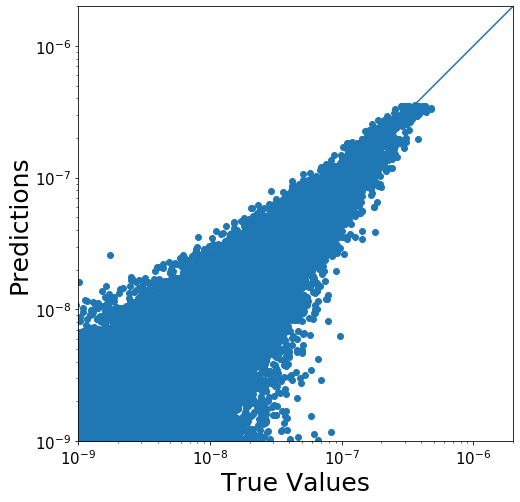

In [49]:

ptest_au2 = np.exp(test_labels2).to_numpy()
ptest_au3 = np.exp(test_labels3).to_numpy()

test_au2 = ptest_au2[:,0]
test_au3 = ptest_au3[:,0]

predict2 = np.exp(model2.predict(normed_test_data2))

test_predict2 = predict2[:,0]

amin, amax = 1e-9, 2e-6

a = plt.axes(aspect='equal')
plt.scatter(test_au2, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


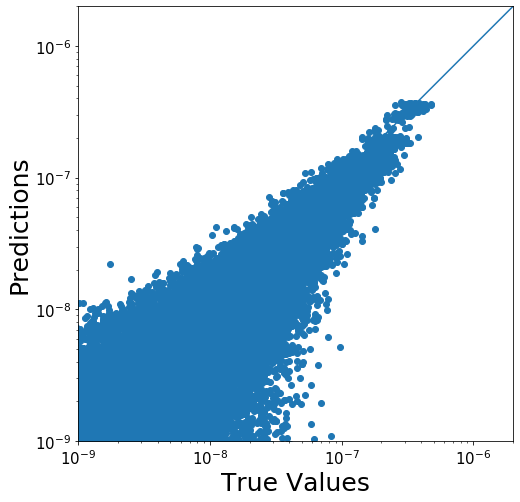

In [50]:
predict3 = np.exp(model3.predict(normed_test_data3))

test_predict3  = predict3[:,0]

a = plt.axes(aspect='equal')
plt.scatter(test_au3, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [51]:
test_dataset3.describe()

Lc             Xc            tau             nu
count  114312.000000  114312.000000  114312.000000  114312.000000
mean       -7.800608     -25.721569      -4.598324       1.998040
std         0.671941       0.491117       3.737306       1.107676
min       -10.008868     -26.690422     -18.069786       0.500000
25%        -8.147650     -26.123439      -7.034030       1.500000
50%        -7.723305     -25.815642      -3.786315       1.500000
75%        -7.270895     -25.339330      -1.344769       2.500000
max        -6.503471     -24.882586      -0.162521       3.500000

In [52]:
qc  = np.exp(np.array(test_dataset3.Lc))
xc  = np.exp(np.array(test_dataset3.Xc))
nue = np.array(test_dataset3.nu)

tau2 = np.exp(np.array(test_dataset3.tau))

## SB2001 autoconversion rate, original and re-trained on current data

In [53]:
kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 
xstar = 2.6e-10   # xstar in kg

au = kcc/(20*xstar) * (nue+2.0)*(nue+4.0)/(nue+1.0)**2 * qc**2 * xc**2

a1 = 600.
p1 = 0.68
taup = np.power(tau2,p1)
phi1 = a1 * taup * (1.0 - taup)**3

a2 = 954.
p2 = 0.773
taup = np.power(tau2,p2)
phi2 = a2 * taup * (1.0 - taup)**3

auSB1 = au * phi1
auSB2 = au * phi2


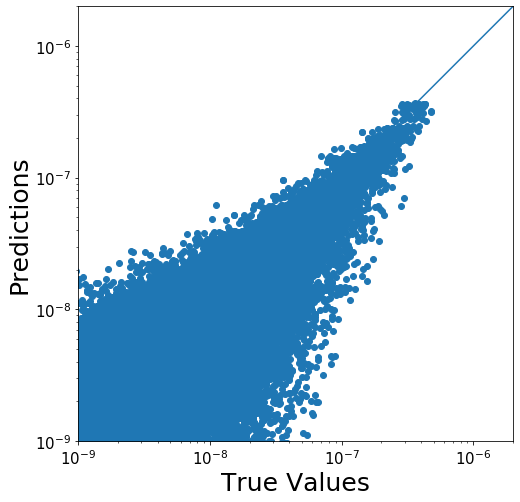

In [54]:
test_predict_sb = auSB2

amin, amax = 1e-9, 2e-6

a = plt.axes(aspect='equal')
plt.scatter(test_au3, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## KK2000 autoconversion

In [55]:

nc = qc/xc * 1e-6  # Nc in CGS

auKK = 1350. * np.power(qc,2.47) * np.power(nc,-1.79)

## Power law regression 

from notebook 'McSnow_autocon_powerlaws'

In [56]:
fac = 7.540743e+13 
a = 2.786325 
b = -1.620419 
c = -0.808443 

nc = qc/xc

# AU = fac * Lc**a * Nc**b * nu**c
auPwr = fac * np.power(qc,a) * np.power(nc,b) * np.power(nue+1,c)  

In [57]:
np.mean(auPwr)

5.307164e-09

In [58]:
np.mean(auKK)

5.8389036e-09

In [59]:
np.exp(model2.predict(normed_test_data2))

array([[1.9776800e-12, 6.5119471e-03],
       [2.8301901e-12, 8.2986243e-03],
       [3.3831551e-12, 9.4028963e-03],
       ...,
       [7.3450694e-09, 2.5733643e+01],
       [5.1107341e-09, 1.6950857e+01],
       [3.6497263e-09, 1.2156071e+01]], dtype=float32)

## Final statistics (DOES NOT WORK HERE!!!), go directly to save models....

In [60]:
au2 = test_predict2
au3 = test_predict3

auTruth = test_au3

In [61]:
np.max(auTruth)

4.7286497e-07

In [62]:
def mean_abs_error(au, auTrue):  
    return np.mean(np.abs(au - auTrue))

def mean_sqr_error(au, auTrue):    
    return np.sqrt(np.mean((au - auTrue)**2))                   

In [63]:
mae2 = mean_abs_error(au2,test_au2)
mae3 = mean_abs_error(au3,test_au3)

maeSB1 = mean_abs_error(auSB1,auTruth)
maeSB2 = mean_abs_error(auSB2,auTruth)
maeKK  = mean_abs_error(auKK,auTruth)
maePwr = mean_abs_error(auPwr,auTruth)

mse2 = mean_sqr_error(au2,test_au2)
mse3 = mean_sqr_error(au3,test_au3)

mseSB1 = mean_sqr_error(auSB1,auTruth)
mseSB2 = mean_sqr_error(auSB2,auTruth)
mseKK  = mean_sqr_error(auKK,auTruth)
msePwr = mean_sqr_error(auPwr,auTruth)

mae = [ mae2, mae3, maeSB1, maeSB2, maeKK, maePwr ]
mse = [ mse2, mse3, mseSB1, mseSB2, mseKK, msePwr ]

In [64]:
mae

[2.329059e-09,
 2.4406284e-09,
 3.4574588e-09,
 2.888975e-09,
 6.426121e-09,
 5.7868457e-09]

In [65]:
mse

[6.472765e-09,
 7.060326e-09,
 1.1235305e-08,
 8.1012095e-09,
 1.7270164e-08,
 1.606931e-08]

In [66]:
labels = list(histories.keys())
labels.append('SB2001')
labels.append('SB new')
labels.append('KK2000')
labels.append('Power')
labels

['Lc-xc-nu-Lr', 'Lc-xc-nu-tau', 'SB2001', 'SB new', 'KK2000', 'Power']

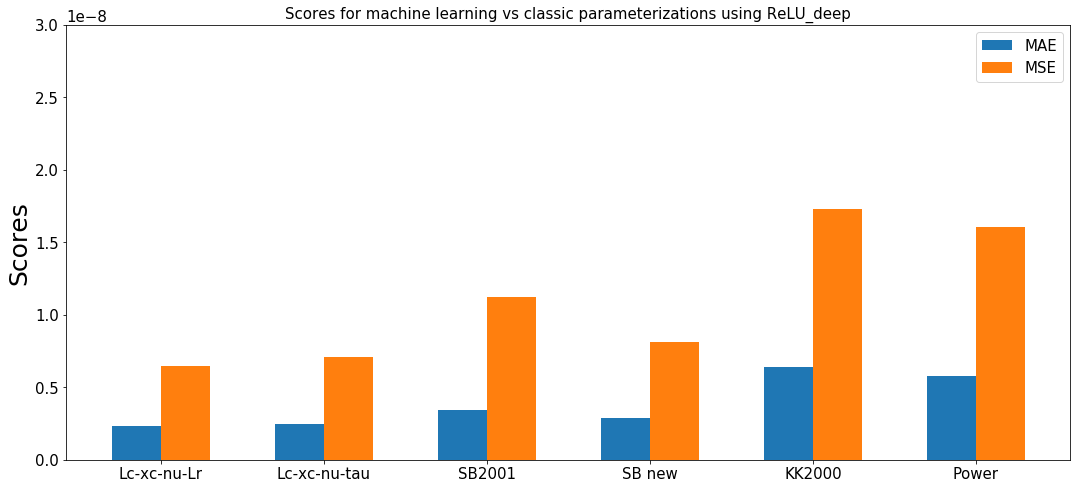

In [67]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs classic parameterizations using '+activ)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

In [68]:
fig.savefig("autocon_withN_v9_barplot_"+activ+"_"+data+".png", bbox_inches='tight', dpi=600)